# Загрузим модель и посмотрим что получилось

In [7]:
import torch
import torch.nn.functional as F
from model import GPT, GPTConfig

In [3]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

model = GPT(GPTConfig(vocab_size=50304))
model.to(device)

load_ckpt_path = '../log/model_28317.pt'
checkpoint = torch.load(load_ckpt_path, map_location=device)
model.load_state_dict(checkpoint['model'])

using device: cuda


<All keys matched successfully>

In [5]:
model.eval()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50304, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50304, bias=False)
)

In [6]:
import tiktoken

enc = tiktoken.get_encoding('gpt2')

# Генерация моделью

In [20]:
def generate(model, prefix="", encoder=enc, max_length=32, num_return_sequences=4, random_seed=42):
    tokens = encoder.encode(prefix)
    tokens = torch.tensor(tokens, dtype=torch.long)
    tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
    xgen = tokens.to(device)
    sample_rng = torch.Generator(device=device)
    sample_rng.manual_seed(random_seed)
    
    while xgen.size(1) < max_length:
        # forward model to get the logits
        with torch.no_grad():
            logits, loss = model(xgen)  # (B, T, vocab_size)
            # take the logits at the last position
            logits = logits[:, -1, :]  # (B, vocab_size)
            # get the probabilities
            probs = F.softmax(logits, dim=-1)
            # do top-k sampling of 50
            # topk_probs here becomes (5, 50), topk_indices is (5, 50)
            topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
            # select a token from top-k probabilities
            # note: miltinomial does not demand the input to sum to 1
            ix = torch.multinomial(topk_probs, 1, generator=sample_rng)  # (B, 1)
            # gather the corresponding indices
            xcol = torch.gather(topk_indices, -1, ix)  # (B, 1)
            # append to the sequence
            xgen = torch.cat((xgen, xcol), dim=1)
    # print the generated text
    results = []
    for i in range(num_return_sequences):
        tokens = xgen[i, :max_length].tolist()
        decoded = encoder.decode(tokens)
        results.append(decoded)
    return results

In [108]:
generate(model, prefix="Artificial intelligence")

['Artificial intelligence is a good thing, but there are probably only a few hundred millions of us who think it. And yet, as I’ve watched',
 "Artificial intelligence (AI) is an emerging field in which we've long known a thing of beauty: intelligent, smart people. We believe that artificial intelligences",
 'Artificial intelligence (AI) will provide artificial intelligence solutions to almost every problem we’ve ever encountered, from the most difficult to the most difficult.\n',
 'Artificial intelligence\n\nHumans are still the future of artificial intelligence, but at least they know a way to interact with each other. The brain is connected']

# То, как модель обучалась

In [23]:
import re

In [24]:
with open('../log/log_last.txt', 'r') as f:
    log = f.read()

In [42]:
train_losses = list(map(float, re.findall(r'\| loss: ([\d]+.[\d]+)', log)))
train_losses[-15:], len(train_losses)

([3.085204,
  3.100019,
  3.065958,
  3.075712,
  3.053665,
  3.081789,
  3.002653,
  3.071181,
  3.068038,
  3.050591,
  3.060568,
  3.056719,
  3.06771,
  3.004445,
  3.105802],
 28178)

In [122]:
val_losses = list(map(float, re.findall(r'step +[\d]+.+\nvalidation loss: ([\d]+.[\d]+)\nsample', log)))
val_losses[-15:], len(val_losses)

([3.303,
  3.2896,
  3.2924,
  3.2929,
  3.2966,
  3.2875,
  3.2869,
  3.2862,
  3.2862,
  3.2927,
  3.2825,
  3.284,
  3.2758,
  3.2935,
  3.2767],
 113)

In [123]:
train_steps = list(map(int, re.findall(r'step +([\d]+)', log)))
train_steps[:15], len(train_steps)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 28178)

In [124]:
val_steps = list(map(lambda x: int(x)+1, re.findall(r'step +([\d]+).+\nvalidation loss:', log)))
val_steps[:15], len(val_steps)

([250,
  500,
  750,
  1000,
  1250,
  1500,
  1750,
  2000,
  2250,
  2500,
  2750,
  3000,
  3250,
  3500,
  3750],
 113)

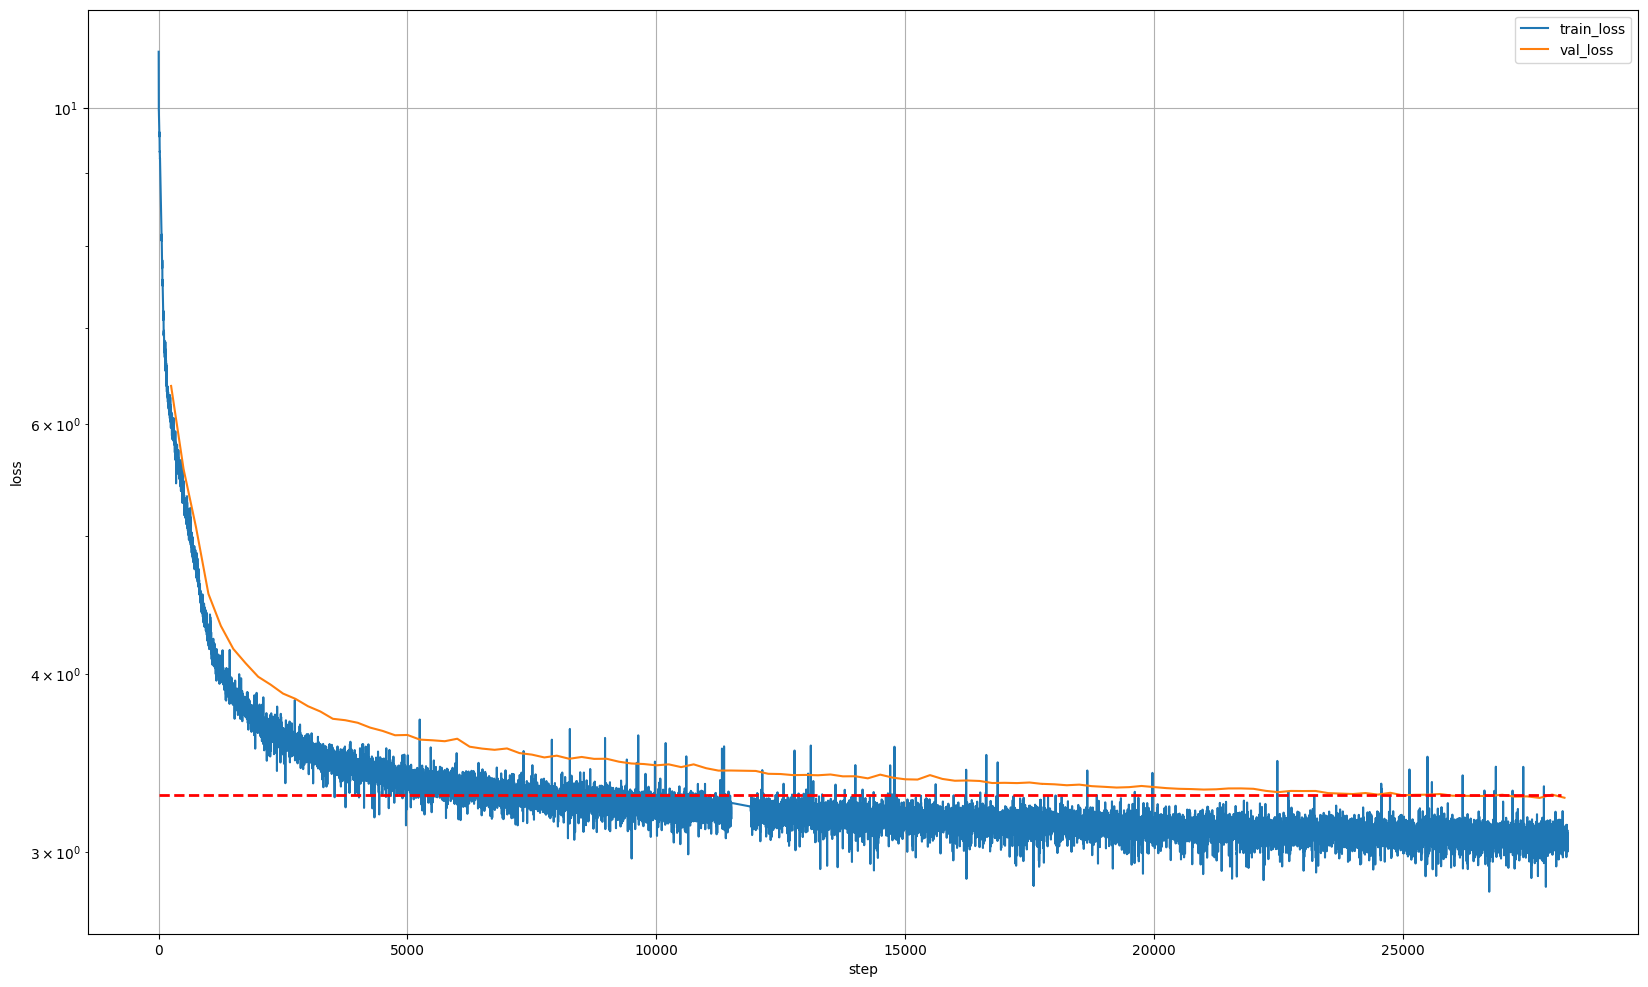

In [140]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))
plt.plot(train_steps, train_losses, label='train_loss')
plt.plot(val_steps, val_losses, label='val_loss')
plt.hlines(y=[3.2924], xmin=0, xmax=len(train_steps), linestyles='dashed', color='red', lw=2)
plt.legend(loc='upper right')
plt.xlabel('step')
plt.ylabel('loss')
plt.yscale('log')
plt.grid(True)